# Using Cassiopeia with spatial genomics

Cassiopeia can be used to analyze spatially-resolved lineage-tracing data.

As first described in Jones, Sun et al, there are several nuances that should be taken into account for spatial data, including:
* Resolution: often times, each "spot" observed in spatial data contains potentially multiple cells. For this reason, care should be taken to not remove "conflicting" intBCs as in the typical workflows
* Sparsity: spatial assays are often less sensitive than traditional single-cell approaches

Cassiopeia now has special functionality to handle spatial data, including approaches to process this data as well as handle the sparsity and resolution issues. One major change is the inclusion of *ambigous* character states, which reflect the fact that multiple high-confidence indels can be observed in a given spot, owing to the non-single-cell nature. We encode these states as tuples, for example in this character matrix:

$$\begin{bmatrix} 1 & 0 & 0 \\ 1 & (2, 1) & 0 \\ 1 & 1 & (2, 3, 4) \end{bmatrix}$$

In the above, we have two ambigous state: the `(2, 1)` ambigous state in the second row, second character; and the `(2, 3, 4)` ambigous state in the third row, third character.

To handle this type of data, we have introduced new functionality in the preprocessing module, which can be read about in the [preprocess.ipynb](./preprocess.ipynb) notebook tutorial. Below, we discuss how one can reconstruct trees using this type of data, as well as how to simulate and benchmark new approaches for spatial lineage tracing data.

We will begin with an example dataset from our recent KP-Spatial study.

In [1]:
from functools import partial
import warnings

import anndata
import cassiopeia as cas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import squidpy as sq

import pyvista as pv
pv.set_jupyter_backend('static')


In [2]:
## Some utility functions for tree plotting
def plot_selection(tree, adata, node, color):
    
    subtree = tree.leaves_in_subtree(node)

    adata.obs['Selection'] = np.nan
    adata.obs.loc[tree.leaves, 'Selection'] = "False"
    adata.obs.loc[subtree, 'Selection'] = "True"
    
    with warnings.catch_warnings():

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3.5))
        cas.pl.plot_matplotlib(
            tree,
            add_root=True,
            indel_priors=None,
            clade_colors={node: color},
            ax=ax1
        )

        adata.uns['Selection_colors'] = ['#838383', color]
        adata.obs['library_id'] = 'puck1'

        sq.pl.spatial_scatter(adata, size=1, library_id='puck1', shape=None, na_color='lightgray', ax=ax2, figsize=(5,5), legend_loc=None)
        sq.pl.spatial_scatter(adata, color=['Selection'],
                            groups = ['True'],
                            library_id='puck1',
                            size=20, ax=ax2, shape=None,
                                scalebar_dx=1.0,
                            scalebar_units='um',
                            scalebar_kwargs={"scale_loc": "bottom", "location": "upper right"})

        sq.pl.spatial_scatter(adata, color=['Selection'], library_id='puck1',
                            groups = ['False'],
                            size=5, ax=ax2, shape=None)


        fig.tight_layout()
        plt.show()

In [4]:
allele_table = pd.read_csv('data/spatial_allele_table.txt', sep='\t')
allele_table = allele_table[~allele_table[['r1', 'r2', 'r3']].isna().any(axis=1)]

indel_priors = pd.read_csv("data/allele_priors.tsv", sep='\t', index_col = 0)
indel_colors = cas.pl.utilities.get_indel_colors(indel_priors, np.random.RandomState(1234))

adata = anndata.read_h5ad('data/spatial_adata.h5ad')

/Users/matthewjones/miniconda3/envs/cas-py11/lib/python3.11/site-packages/anndata/_core/anndata.py:1776: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Before creating the character matrix, we can apply some filtering to the allele table and mark the spots that get filtered out due to
quality issues. These are spots we can potentially rescue with imputation downstream.

Here, we have stored values like PercentUncut (i.e., percent `0` character) and target site UMIs in the anndata. You can draw these values from the allele table or compute them yourself and store them separately. We are not filtering on percent uncut, but we will remove spots with poor UMI support and try to rescue them later.

In [5]:
overlapping_cells = np.intersect1d(
    adata[adata.obs["TS-UMI"] >= 3].obs_names,
    allele_table["cellBC"].values,
)

pre_filtered_cells = np.intersect1d(adata.obs_names, allele_table["cellBC"].unique())
overlapping_cells = np.intersect1d(
    adata.obs_names,
    allele_table[allele_table["UMI"] >= 3]["cellBC"].unique(),
)
allele_table = allele_table[allele_table["cellBC"].isin(overlapping_cells)]

# create unimputed character matrix
(
    character_matrix,
    priors,
    state_to_indel,
) = cas.pp.convert_alleletable_to_character_matrix(
    allele_table,
    mutation_priors=indel_priors,
    collapse_duplicates=False,
    allele_rep_thresh=0.98,
)

Dropping the following intBCs due to lack of diversity with threshold 0.98: ['ACGTCTTCGTAGTGr1']


Processing characters:   0%|          | 0/32 [00:00<?, ?it/s]

In [6]:
for character in state_to_indel:
    state_to_indel[character][-1] = np.nan

Now that we have the character matrix, let's compute some simple statistics around drop out.

Mean dropout per spot: 0.75


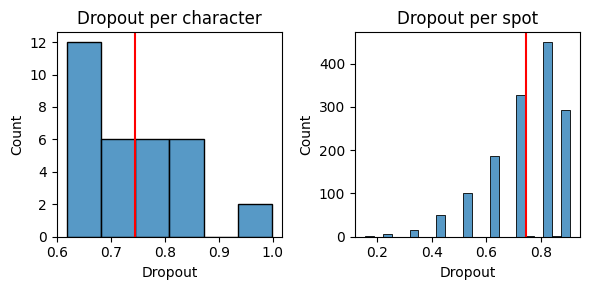

In [7]:
dropout_per_character = character_matrix.apply(lambda x: len(x[x==-1]) / len(x), axis=0)
dropout_per_cell = character_matrix.apply(lambda x: len(x[x==-1]) / len(x), axis=1)

print(f"Mean dropout per spot: {round(np.mean(dropout_per_cell), 2)}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))

sns.histplot(dropout_per_character, ax=ax1)
ax1.axvline(x = np.mean(dropout_per_character), color='red')
ax1.set_title("Dropout per character")
ax1.set_xlabel("Dropout")

sns.histplot(dropout_per_cell, ax=ax2)
ax2.axvline(x = np.mean(dropout_per_cell), color='red')
ax2.set_title("Dropout per spot")
ax2.set_xlabel("Dropout")

fig.tight_layout()
plt.show()

Let's add back in the cells pre-filtered to try and impute them.

In [8]:
# add in cells that did not have high-confidence target sites
missing_cells = np.setdiff1d(pre_filtered_cells, character_matrix.index)
print(f">> Adding back in {len(missing_cells)} cells for imputation.")
missing_cell_character_matrix = pd.DataFrame(
    np.zeros(
        (len(missing_cells), character_matrix.shape[1]), dtype=int
    ),
    index=missing_cells,
    columns=character_matrix.columns,
)
missing_cell_character_matrix.to_numpy().fill(-1)
character_matrix = pd.concat(
    [character_matrix, missing_cell_character_matrix]
)

>> Adding back in 3465 cells for imputation.


In [9]:
imputed_character_matrix = cas.sp.impute_alleles_from_spatial_data(
    character_matrix,
    adata,
    neighborhood_radius=30.0,
    imputation_hops = 2,
    num_imputation_iterations = 5
)

>> Imputation round 1...


100%|██████████████████████████████████████████████████████████████████████████| 145093/145093 [00:03<00:00, 39515.66it/s]


>> Imputation round 2...


100%|██████████████████████████████████████████████████████████████████████████| 133388/133388 [00:03<00:00, 44366.86it/s]


>> Imputation round 3...


100%|██████████████████████████████████████████████████████████████████████████| 127022/127022 [00:02<00:00, 47860.01it/s]


>> Imputation round 4...


100%|██████████████████████████████████████████████████████████████████████████| 123538/123538 [00:02<00:00, 50138.94it/s]


>> Imputation round 5...


100%|██████████████████████████████████████████████████████████████████████████| 121665/121665 [00:02<00:00, 51503.53it/s]


In [10]:
# remove spots with no information

imputed_character_matrix = imputed_character_matrix[
    (
        (imputed_character_matrix == -1).sum(axis=1)
        / imputed_character_matrix.shape[1]
    )
    < 1.0
]


Mean dropout per spot after imputation: 0.75 --> 0.61


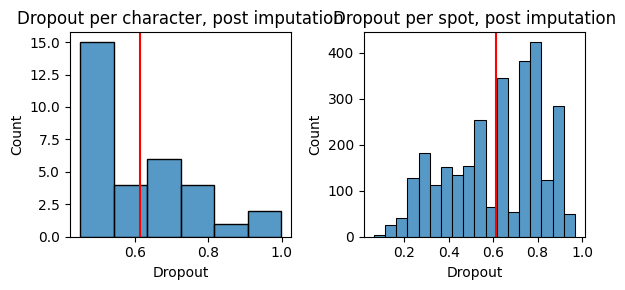

In [11]:
imputed_dropout_per_character = imputed_character_matrix.apply(lambda x: len(x[x==-1]) / len(x), axis=0)
imputed_dropout_per_cell = imputed_character_matrix.apply(lambda x: len(x[x==-1]) / len(x), axis=1)

print(f"Mean dropout per spot after imputation: "
    f"{round(np.mean(dropout_per_cell), 2)} --> {round(np.mean(imputed_dropout_per_cell), 2)}")


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))

sns.histplot(imputed_dropout_per_character, ax=ax1)
ax1.axvline(x = np.mean(imputed_dropout_per_character), color='red')
ax1.set_title("Dropout per character, post imputation")
ax1.set_xlabel("Dropout")

sns.histplot(imputed_dropout_per_cell, ax=ax2)
ax2.axvline(x = np.mean(imputed_dropout_per_cell), color='red')
ax2.set_title("Dropout per spot, post imputation")
ax2.set_xlabel("Dropout")

fig.tight_layout()
plt.show()

Now that we have a character matrix, we can reconstruct lineages using one of several algorithms in the Cassiopeia package.

To handle the conflicts in allele state that come with spatial data, we have introduced new reconstruction approaches. For example, we have extended the Cassiopeia-Greedy algorithm to handle ambiguous states. We also have added new functionality to reconstruct trees using distance-based algorithms like Neighbor-Joining over ambigous states. We'll show an example using the Neighbor-Joining approach.

At the core of this modified approach is the `cluster_dissimilarity` function which will compute an aggregate dissimilarity between sets of points (similar to how hiearchical clustering would aggregate dissimilarity across sets). We use this in the example below:

In [15]:
# vg_solver = cas.solver.VanillaGreedySolver()

tree = cas.data.CassiopeiaTree(character_matrix = imputed_character_matrix)

dissimilarity_function = cas.solver.dissimilarity_functions.weighted_hamming_distance

cluster_dissimilarity_function = partial(
        partial(
            cas.solver.dissimilarity_functions.cluster_dissimilarity,
            dissimilarity_function,
        )
    )

nj_solver = cas.solver.NeighborJoiningSolver(
        add_root=True, dissimilarity_function=cluster_dissimilarity_function
    )

nj_solver.solve(tree)

# vg_solver.solve(tree)

tree.collapse_mutationless_edges(infer_ancestral_characters=True)


/Users/matthewjones/miniconda3/envs/cas-py11/lib/python3.11/site-packages/cassiopeia/data/utilities.py:235: CassiopeiaTreeWarning: Failed to numbaize dissimilarity function. Falling back to Python.
  warnings.warn(


  0%|          | 0/2911 [00:00<?, ?it/s]

filling in multiindex table:   0%|          | 0/35629 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 18.44it/s]


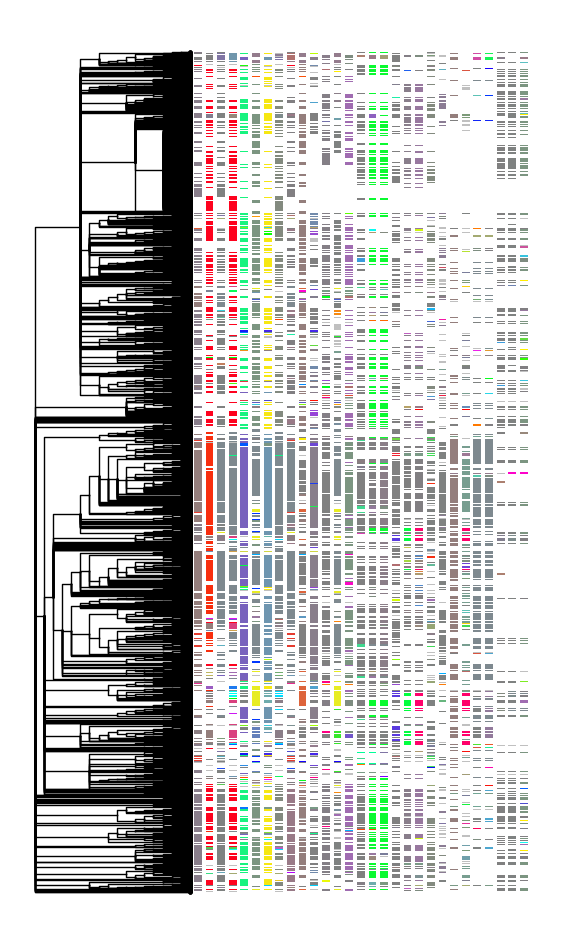

In [16]:
# create reconciled allele table for plotting
allele_table_to_plot = cas.pp.convert_character_matrix_to_allele_table(imputed_character_matrix, state_to_indel, keep_ambiguous=False)
allele_table_to_plot['r1'] = allele_table_to_plot['r1'].astype(str)

# filter out lowly abundant characters
percent_present = allele_table_to_plot.groupby('intBC').agg({'r1': len}) / allele_table_to_plot['cellBC'].nunique()
to_keep = percent_present[(percent_present.values > 0.15)].index

allele_table_filtered = allele_table_to_plot[allele_table_to_plot['intBC'].isin(to_keep)]
allele_table_filtered['intBC'].unique()

h = plt.figure(figsize=(7,12))
ax = plt.gca()
cas.pl.plot_matplotlib(
    tree,
    orient='right',
    allele_table=allele_table_filtered,
    add_root=False,
    figsize=(3.5, 6),
    indel_colors=indel_colors,
    ax=ax,
)
plt.show()

/Users/matthewjones/miniconda3/envs/cas-py11/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/Users/matthewjones/miniconda3/envs/cas-py11/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/Users/matthewjones/miniconda3/envs/cas-py11/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


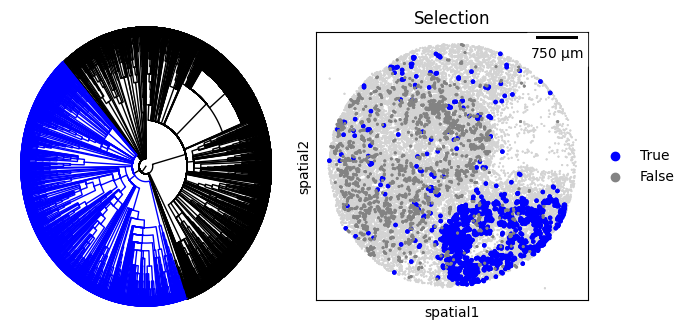

/Users/matthewjones/miniconda3/envs/cas-py11/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/Users/matthewjones/miniconda3/envs/cas-py11/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/Users/matthewjones/miniconda3/envs/cas-py11/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


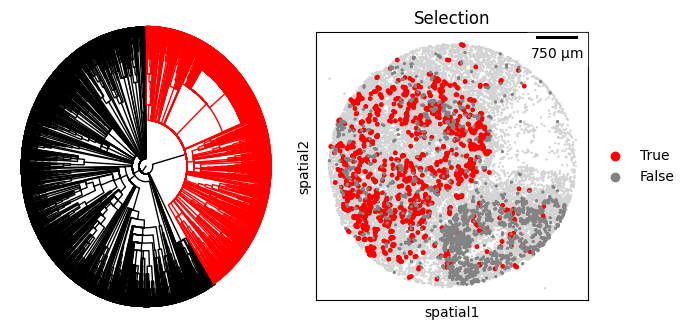

In [18]:
node = tree.root
# find three largest subclades
sizes = np.array([len(tree.leaves_in_subtree(child)) for child in tree.children(node)])
iid = np.argsort(-sizes)[:3]

colors = ['blue', 'red', '#E69F00', '#D34818']
clade_to_colors = {}
for _iter, child in zip(range(2), np.array(tree.children(node))[iid]): 
    clade_to_colors[child] = colors[_iter]
    plot_selection(tree, adata, child, colors[_iter])


We often find that the major splits in the tree are reflected as spatially-segregated populations as above. We encourage the user to experiment with several solvers; we have found that a hybrid solver consisting of Cassiopeia-Greedy and Neighbor-Joining to work well with this spatial data.

## Simulating spatial lineage data

Another key capability of the Cassiopeia spatial library is to simulate spatially-resolved data for the purposes of theoretical work and benchmarking of new algorithms. Below, we briefly walk through the basics of simulating trees. 

One can then take these simulated trees and fit them into any of the benchmarking code described in the [benchmark.ipynb](./benchmark.ipynb) tutorial.

In [5]:
# define lineage tracing data parameters

number_of_cassettes = 39
size_of_cassette = 1

# Specify the mutation proportion
mutation_proportion = 0.5
get_mutation_rate= lambda depth: -np.log2(1-mutation_proportion)/depth

number_of_states = 100
state_generating_distribution = lambda: np.random.exponential(1e-5)

# Specify the dropout proportions. Note that the heritable missing data proportion will be
# total_dropout_proportion - stochastic_proportion
total_dropout_proportion = 0.0
stochastic_proportion = 0.0
heritable_proportion = total_dropout_proportion - stochastic_proportion

get_heritable_rate = lambda depth: -np.log2(1-heritable_proportion)/depth

Below we set up three simulators:

1. A `BirthDeathFitnessSimulator` that simulates a tree topology according to user-specified birth and death rates.
2. A `LineageTracingDataSimulator`, specifically a `Cas9LineageTracingDataSimulator` that deposits edits along a tree according to the principles of a Cas9 tracer.
3. A `ClonalSpatialDataSimulator` that overlays spatial coordinates on the reconstructed tree. We define an arbitrary cube of unit coordinates

In [6]:
tree_simulator = lambda num_extant: cas.sim.BirthDeathFitnessSimulator(
    birth_waiting_distribution = lambda scale: np.random.lognormal(mean = np.log(scale),sigma = .5),
    initial_birth_scale = 1,
    death_waiting_distribution = lambda: np.random.uniform(0,4),
    mutation_distribution = lambda: 1,
    fitness_distribution = lambda: np.random.normal(0, .25),
    fitness_base = 1,
    num_extant = num_extant)

lt_simulator = lambda depth: cas.simulator.Cas9LineageTracingDataSimulator(
    number_of_cassettes = number_of_cassettes,
    size_of_cassette = size_of_cassette,
    mutation_rate = get_mutation_rate(depth),
    number_of_states=number_of_states,
    state_generating_distribution=state_generating_distribution,
    heritable_silencing_rate=get_heritable_rate(depth),
    stochastic_silencing_rate=stochastic_proportion,
    collapse_sites_on_cassette=True)

shape = (1,1)
spatial_simulator = cas.sim.ClonalSpatialDataSimulator(shape=shape,)

Now we'll simulate the data - first the tree, then the lineage data, and then finally the spatial data. We'll end by sampling randomly leaves.

In [7]:
np.random.seed(1234678)

simulated_tree = tree_simulator(4000).simulate_tree()
lt_simulator(simulated_tree.get_mean_depth_of_tree()).overlay_data(simulated_tree)
spatial_simulator.overlay_data(simulated_tree)
simulated_tree = cas.sim.UniformLeafSubsampler(ratio = .25).subsample_leaves(simulated_tree)

# relabel nodes
node_map = {l: f'cell{l}' for l in simulated_tree.leaves}
simulated_tree.relabel_nodes(node_map)
simulated_tree.character_matrix.index = [f'cell{l}' for l in simulated_tree.character_matrix.index]
simulated_tree.cell_meta.index = simulated_tree.cell_meta.index.map(node_map)

simulated_tree.collapse_unifurcations()

  0%|          | 0/1000 [00:00<?, ?it/s]

filling in multiindex table:   0%|          | 0/39000 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 37.96it/s]


(<Figure size 500x1000 with 1 Axes>, <Axes: >)

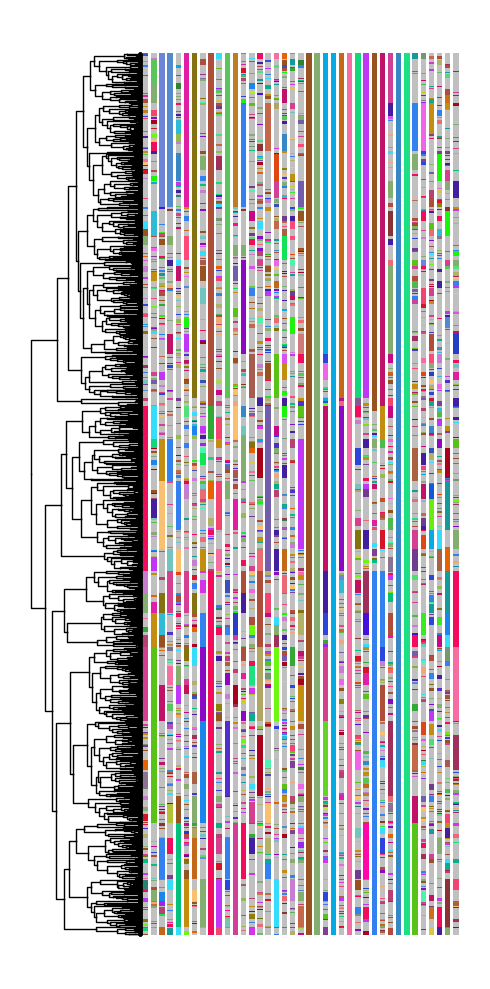

In [5]:
allele_table = cas.pp.convert_character_matrix_to_allele_table(simulated_tree.character_matrix.astype(int))

cas.pl.plot_matplotlib(simulated_tree, orient='right',
                       allele_table=allele_table.astype(str),
                       figsize=(5, 10),
                       extend_branches = False)

In [8]:
simulated_adata = anndata.AnnData(obs=pd.DataFrame(index=simulated_tree.leaves))
simulated_adata.obs['library_id'] = 'simulated_puck'

simulated_adata.obsm['spatial'] = simulated_tree.cell_meta[['spatial_0', 'spatial_1']].to_numpy()

/Users/matthewjones/miniconda3/envs/cas-py11/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/Users/matthewjones/miniconda3/envs/cas-py11/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/Users/matthewjones/miniconda3/envs/cas-py11/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


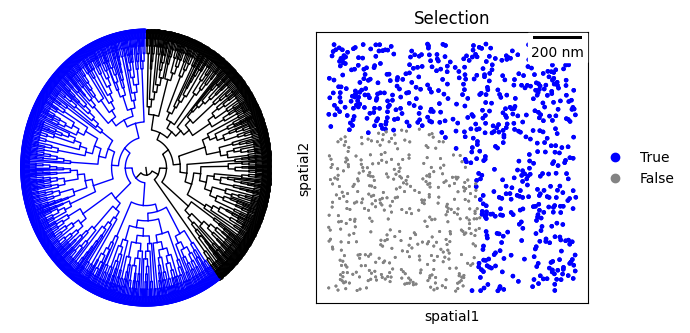

/Users/matthewjones/miniconda3/envs/cas-py11/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/Users/matthewjones/miniconda3/envs/cas-py11/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/Users/matthewjones/miniconda3/envs/cas-py11/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


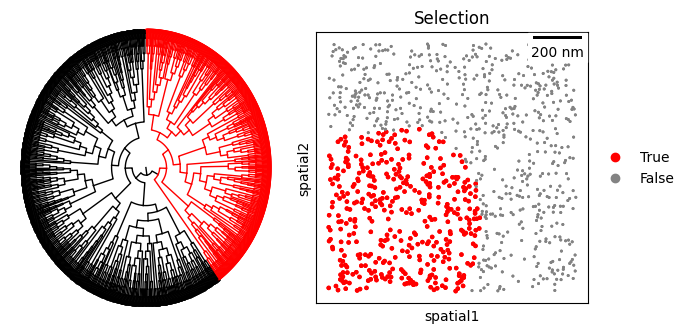

In [9]:
node = simulated_tree.root

# find three largest subclades
sizes = np.array([len(simulated_tree.leaves_in_subtree(child)) for child in simulated_tree.children(node)])
iid = np.argsort(-sizes)[:3]

colors = ['blue', 'red', '#E69F00', '#D34818']
clade_to_colors = {}
for _iter, child in zip(range(3), np.array(simulated_tree.children(node))[iid]): 
    clade_to_colors[child] = colors[_iter]
    plot_selection(simulated_tree, simulated_adata, child, colors[_iter])


### Modifying the sparsity and resolution of the data

As previously mentioned, spatial data can have limited resolution and increased sparsity. We can introduce these features into the simulated data.

For example, we can introduce dropout randomly as so:

  0%|          | 0/4000 [00:00<?, ?it/s]

filling in multiindex table:   0%|          | 0/93765 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 12.46it/s]


(<Figure size 500x1000 with 1 Axes>, <Axes: >)

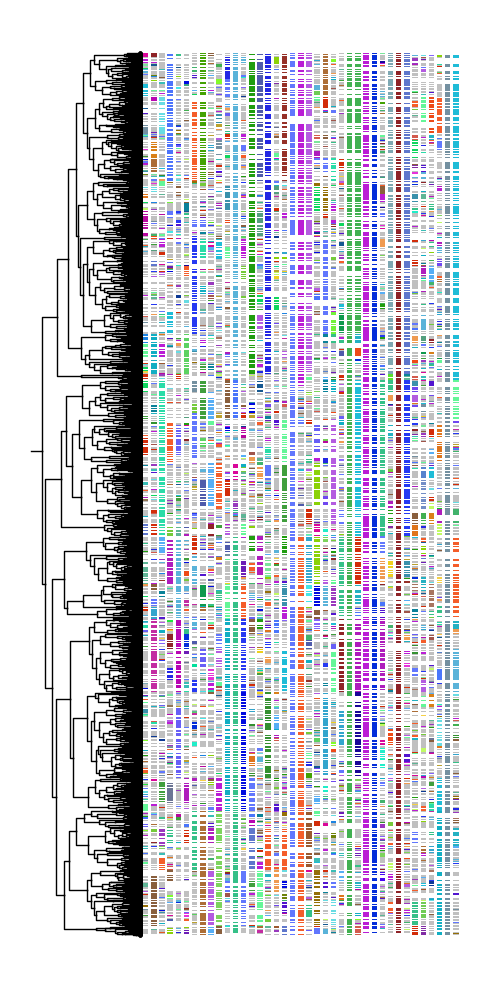

In [37]:
def dropout_cassettes(_tree, missing_rate = .3, missing_state = -1, cassette_size=3):
    character_matrix = _tree.character_matrix
    missing = np.random.choice([0,1],p=[1-missing_rate,missing_rate],
                    size=(character_matrix.shape[0],int(character_matrix.shape[1]/cassette_size)))
    missing = np.repeat(missing,3,axis=1)
    character_matrix[missing
    == 1] = missing_state
    _tree.character_matrix = character_matrix
    _tree.set_character_states_at_leaves()


# drop out data
missing_rate = 0.4
missing_tree = simulated_tree.copy()
dropout_cassettes(missing_tree, missing_rate)

allele_table_missing = cas.pp.convert_character_matrix_to_allele_table(missing_tree.character_matrix.astype(int))

cas.pl.plot_matplotlib(missing_tree, orient='right',
                       allele_table=allele_table_missing.astype(str),
                       figsize=(5, 10),
                       extend_branches = False)

We can also simulate low resolution spatail assays. Specifically, we can modify the pipeline above by introducing a `SupercellularSampler` to group together leaves. Then we'll overlay spatial data.

In [31]:
supercellular_sampler = cas.sim.SupercellularSampler(ratio=0.3) # merge together 30% of cells

In [32]:
np.random.seed(1234678)

simulated_tree_lowres = tree_simulator(1000).simulate_tree()
lt_simulator(simulated_tree_lowres.get_mean_depth_of_tree()).overlay_data(simulated_tree_lowres)
simulated_tree_lowres = supercellular_sampler.subsample_leaves(simulated_tree_lowres)
spatial_simulator.overlay_data(simulated_tree_lowres)
simulated_tree_lowres = cas.sim.UniformLeafSubsampler(ratio = .25).subsample_leaves(simulated_tree_lowres)

# relabel nodes
node_map = {l: f'cell{l}' for l in simulated_tree_lowres.leaves}
simulated_tree_lowres.relabel_nodes(node_map)
simulated_tree_lowres.character_matrix.index = [f'cell{l}' for l in simulated_tree_lowres.character_matrix.index]
simulated_tree_lowres.cell_meta.index = simulated_tree_lowres.cell_meta.index.map(node_map)

simulated_tree_lowres.collapse_unifurcations()

In [36]:
# we can see the ambiguous states in the bottom of the character matrix
simulated_tree_lowres.character_matrix.tail(5)        

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
cell2632-2821-2693,"(0, 67)","(16, 91)","(0, 11, 20)","(0, 91)","(0, 51)","(48,)","(0, 11)","(18, 74)","(40, 33, 46)","(80, 50)",...,"(4, 20)","(0, 50)","(0, 33, 61)","(0, 23)","(0, 31)","(0,)","(0, 24)","(0, 33)","(0, 22)","(0, 62)"
cell2809-2658,"(67, 91)","(16, 95)","(0, 50)","(33, 91)","(43, 68)","(48,)","(16, 71)","(74, 18)","(0, 46)","(0, 50)",...,"(4, 37)","(0, 50)","(0, 95)","(0, 23)","(0,)","(0, 91)","(24, 0)","(0, 33)","(26, 11)","(8, 0)"
cell2959-2500,"(67, 29)","(16, 95)","(0, 50)","(0, 91)","(0,)","(48,)","(0, 18)","(18, 74)","(40, 46)","(0, 50)",...,"(0, 4)","(24, 50)","(95, 63)","(0, 23)","(0, 17)","(0, 88)","(0, 69)","(24, 33)","(0, 56)","(0, 4)"
cell2107-3143,"(0, 67)","(16,)","(0,)","(91,)","(0, 91)","(48,)","(16, 13)","(18,)","(0, 81)","(33, 50)",...,"(4,)","(50,)","(0,)","(23,)","(0, 50)","(0,)","(0, 95)","(0,)","(0, 26)","(0, 46)"
cell2807-3427,"(56,)","(0, 33)","(0, 33)","(0, 61)","(0, 61)","(48,)","(0, 51)","(74,)","(46,)","(0, 23)",...,"(46, 6)","(33,)","(33,)","(0,)","(0,)","(40, 0)","(8, 0)","(33,)","(0,)","(0, 46)"


### Interactive viewing

We also have an interactive viewer that you can use to investigate the spatial phylogenies. Launching this in a jupyter notebook is difficult and requires special proxy settings, but you can use the following codeblock to generate this viewer in a terminal session:

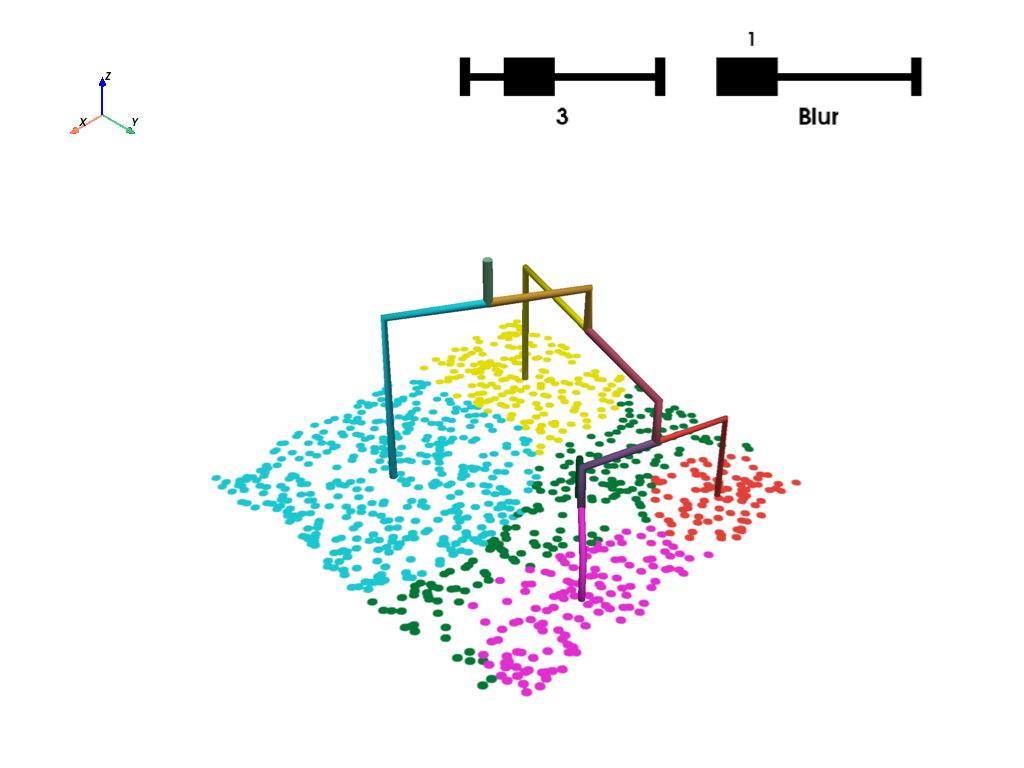

In [10]:
labels = cas.pl.labels_from_coordinates(simulated_tree, attribute_key='spatial')

tree3d = cas.pl.Tree3D(simulated_tree, labels, attribute_key='spatial')
tree3d.plot(show=True)